In [17]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import random
import time

from torch.utils.data import DataLoader

import torch.optim as optim
import torch.nn as nn
import torch

import datetime
import torchaudio
import os

DATASET_PATH = './datasets/'
MODEL_SAVE_PATH = './models/'
BATCH_SIZE = 32

RANDOM_SEED = time.time()
torch.manual_seed(RANDOM_SEED)

device = torch.device('mps')

In [18]:
dataset_dict = dict()
dataset_list = os.listdir(DATASET_PATH)
minimum_length = float('inf')

for dataset_name in tqdm(dataset_list):
    dataset_path = os.path.join(DATASET_PATH, dataset_name)
    dataset_dict[dataset_name], _ = torchaudio.load(dataset_path)
    if dataset_dict[dataset_name].shape[1] < minimum_length:
        minimum_length = dataset_dict[dataset_name].shape[1]

# 모든 데이터를 정확히 32000으로 맞추기
TARGET_LENGTH = 32000
for dataset_name in tqdm(dataset_list):
    data = dataset_dict[dataset_name]
    current_length = data.shape[1]
    
    if current_length < TARGET_LENGTH:
        # 부족한 길이
        pad_amount = TARGET_LENGTH - current_length
        # 마지막 pad_amount개 샘플을 맨 앞에 붙임
        padding = data[:, -pad_amount:]
        dataset_dict[dataset_name] = torch.cat([padding, data], dim=1)
    elif current_length > TARGET_LENGTH:
        # 초과한 경우 맨 앞에서 자르기
        dataset_dict[dataset_name] = data[:, :TARGET_LENGTH]

  0%|          | 0/968 [00:00<?, ?it/s]/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see ht

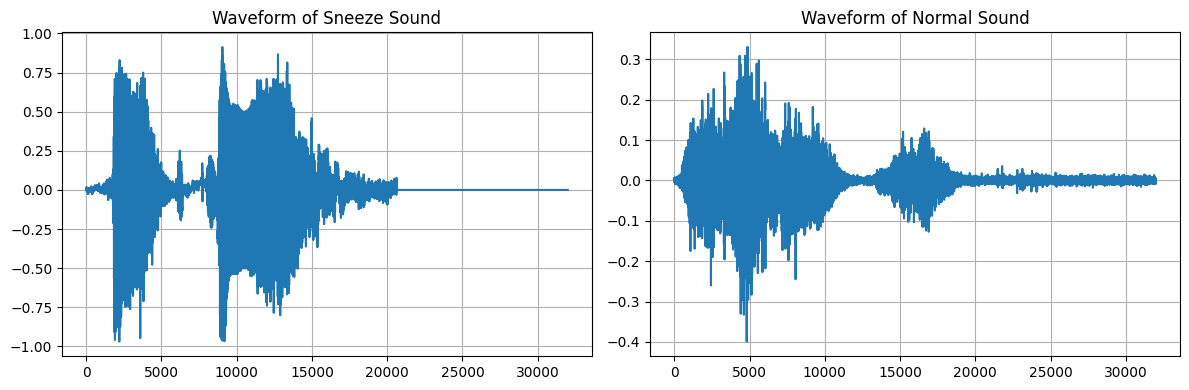

Sneeze Sound Shape:  torch.Size([1, 32000])
Sneeze Sound Shape:  torch.Size([1, 32000])


In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.grid()
plt.title("Waveform of Sneeze Sound")
plt.plot(dataset_dict['sneeze299.wav'].t().numpy())

plt.subplot(1, 2, 2)
plt.grid()
plt.title("Waveform of Normal Sound")
plt.plot(dataset_dict['sneeze266.wav'].t().numpy())

plt.tight_layout()
plt.show() 

print("Sneeze Sound Shape: ", dataset_dict['sneeze299.wav'].shape)
print("Sneeze Sound Shape: ", dataset_dict['sneeze266.wav'].shape)

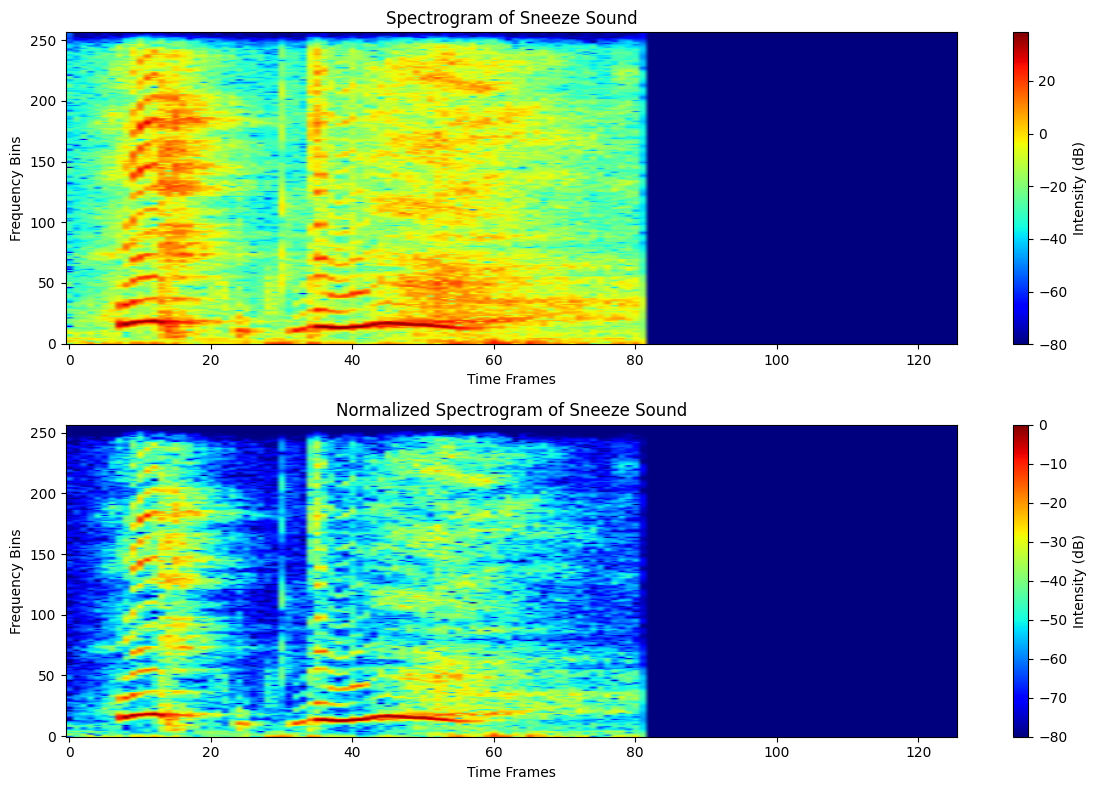

In [20]:
fft_data = torchaudio.transforms.Spectrogram(n_fft=512, hop_length=256)(dataset_dict['sneeze299.wav'])
fft_data_normalized = (fft_data - fft_data.min()) / (fft_data.max() - fft_data.min())

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.imshow(10 * torch.log10(fft_data[0] + 1e-8).numpy(), aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label='Intensity (dB)')
plt.title("Spectrogram of Sneeze Sound")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

plt.subplot(2, 1, 2)
plt.imshow(10 * torch.log10(fft_data_normalized[0] + 1e-8).numpy(), aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label='Intensity (dB)')
plt.title("Normalized Spectrogram of Sneeze Sound")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

plt.tight_layout()
plt.show()

# Data pre-processing

In [21]:
# Normalized 0 to 1 datasets
normalized_dataset_dict = dict()
for dataset_name in dataset_list:
    data = dataset_dict[dataset_name]
    normalized_data = (data - data.min()) / (data.max() - data.min())
    normalized_dataset_dict[dataset_name] = normalized_data

print("Normalized Sneeze Sound Shape: ", normalized_dataset_dict['sneeze299.wav'].shape)

Normalized Sneeze Sound Shape:  torch.Size([1, 32000])


In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dict):
        self.data = []
        for key in dataset_dict:
            self.data.append(dataset_dict[key])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx].to(device)
    
dataset = Dataset(normalized_dataset_dict)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
print(f"Dataset shape: {dataset[0].shape}")

Dataset shape: torch.Size([1, 32000])


# Modeling

In [24]:
class CRNN_AutoEncoder(nn.Module):
    def __init__(self, seq_length=32000, latent_dim=128):
        """
        CRNN (Convolutional Recurrent Neural Network) AutoEncoder
        - Conv1d로 특징 추출 및 시간 축 압축
        - GRU로 시간 정보 학습
        - 가볍고 효율적 (RPi 최적화)
        """
        super(CRNN_AutoEncoder, self).__init__()
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        
        # ============ Encoder ============
        # Conv1d blocks: 1 -> 32 -> 64 -> 128 채널
        # 총 8배 압축 (32000 -> 4000)
        self.enc_conv1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=16, stride=2, padding=7),  # 32000 -> 16000
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=8, stride=2, padding=3),  # 16000 -> 8000
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),  # 8000 -> 4000
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )
        
        # GRU encoder
        self.gru_enc = nn.GRU(input_size=256, hidden_size=64, num_layers=1, 
                             batch_first=True, bidirectional=False)
        
        # Bottleneck (Latent space)
        self.fc_enc = nn.Linear(64, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 64)
        
        # ============ Decoder ============
        # GRU decoder
        self.gru_dec = nn.GRU(input_size=64, hidden_size=256, num_layers=1, 
                             batch_first=True, bidirectional=False)
        
        # ConvTranspose1d blocks: 128 -> 64 -> 32 -> 1 채널
        # 총 8배 확대 (4000 -> 32000)
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),  # 4000 -> 8000
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )
        
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=8, stride=2, padding=3, output_padding=0),  # 8000 -> 16000
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose1d(64, 1, kernel_size=16, stride=2, padding=7, output_padding=0),  # 16000 -> 32000
            nn.Tanh()  # 출력을 [-1, 1] 범위로
        )

    def forward(self, x):
        # x: [B, 1, L]
        
        # ============ Encoder ============
        enc_c1 = self.enc_conv1(x)      # [B, 32, 16000]
        enc_c2 = self.enc_conv2(enc_c1) # [B, 64, 8000]
        enc_c3 = self.enc_conv3(enc_c2) # [B, 128, 4000]
        
        # Conv output을 GRU input으로: [B, 128, 4000] -> [B, 4000, 128]
        enc_rnn_in = enc_c3.permute(0, 2, 1)
        _, hidden = self.gru_enc(enc_rnn_in)  # hidden: [1, B, 64]
        
        # Bottleneck
        z = self.fc_enc(hidden.squeeze(0))  # [B, latent_dim]
        
        # ============ Decoder ============
        dec_init = self.fc_dec(z)  # [B, 64]
        dec_rnn_in = dec_init.unsqueeze(1)  # [B, 1, 64]
        
        # GRU decoder (시간 축 복원)
        # latent vector에서 시간 축 길이만큼 생성
        dec_rnn_in = dec_rnn_in.expand(-1, 4000, -1)  # [B, 4000, 64]
        dec_rnn_out, _ = self.gru_dec(dec_rnn_in)  # [B, 4000, 128]
        
        # RNN output을 Conv input으로: [B, 4000, 128] -> [B, 128, 4000]
        dec_c_in = dec_rnn_out.permute(0, 2, 1)
        
        # ConvTranspose
        dec_c3 = self.dec_conv3(dec_c_in)  # [B, 64, 8000]
        dec_c2 = self.dec_conv2(dec_c3)    # [B, 32, 16000]
        recon = self.dec_conv1(dec_c2)     # [B, 1, 32000]
        
        # Ensure exact length
        return recon[:, :, :self.seq_length]

# instantiate and move to device
model = CRNN_AutoEncoder(seq_length=TARGET_LENGTH, latent_dim=128).to(device)
print(model)
print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")

CRNN_AutoEncoder(
  (enc_conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(16,), stride=(2,), padding=(7,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc_conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(8,), stride=(2,), padding=(3,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc_conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gru_enc): GRU(256, 64, batch_first=True)
  (fc_enc): Linear(in_features=64, out_features=128, bias=True)
  (fc_dec): Linear(in_features=128, out_features=64, bias=True)
  (gru_dec): GRU(64, 256, batch_first=True)
  (dec_conv3): Sequential(
    (0): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(12

In [25]:
dummpy_input = torch.randn(BATCH_SIZE, 1, TARGET_LENGTH).to(device)
dummpy_output = model(dummpy_input)
print(f"Input shape: {dummpy_input.shape}, Output shape: {dummpy_output.shape}")

Input shape: torch.Size([32, 1, 32000]), Output shape: torch.Size([32, 1, 32000])


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

In [27]:
def snr(original, reconstructed):
    signal_power = torch.mean(original ** 2)
    noise_power = torch.mean((original - reconstructed) ** 2)
    snr_value = 10 * torch.log10(signal_power / (noise_power + 1e-8))
    return snr_value

# Model Train

In [ ]:
train_loss, val_loss = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in dataloader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    train_loss.append(epoch_loss)
    
    with torch.no_grad():
        model.eval()
        val_running_loss = 0.0
        for data in dataloader:
            outputs = model(data)
            loss = criterion(outputs, data)
            val_running_loss += loss.item() * data.size(0)

        val_snr = snr(data, outputs)
        val_epoch_loss = val_running_loss / len(dataloader.dataset)
        val_loss.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.8f}, Val Loss: {val_epoch_loss:.8f}, Val SNR: {val_snr:.8f} dB")

Epoch [1/50], Train Loss: 30.48010049, Val Loss: 28.74524053, Val SNR: -5.87029886 dB
Epoch [2/50], Train Loss: 21.35265325, Val Loss: 27.27030825, Val SNR: -4.33902693 dB
Epoch [3/50], Train Loss: 22.08225769, Val Loss: 25.33055060, Val SNR: -2.94138551 dB
Epoch [4/50], Train Loss: 22.17716857, Val Loss: 22.16718957, Val SNR: -2.94764304 dB
Epoch [5/50], Train Loss: 22.18826992, Val Loss: 22.19299977, Val SNR: -2.69734001 dB
Epoch [6/50], Train Loss: 22.17807103, Val Loss: 22.19048596, Val SNR: -2.58851981 dB
Epoch [7/50], Train Loss: 22.18913009, Val Loss: 22.18972354, Val SNR: -2.50368643 dB


In [ ]:
model_save_name = f"autoencoder_model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, model_save_name))

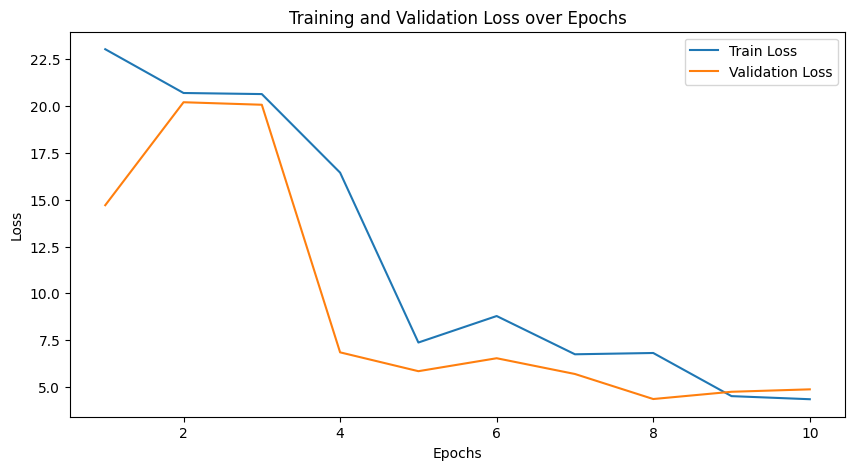

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

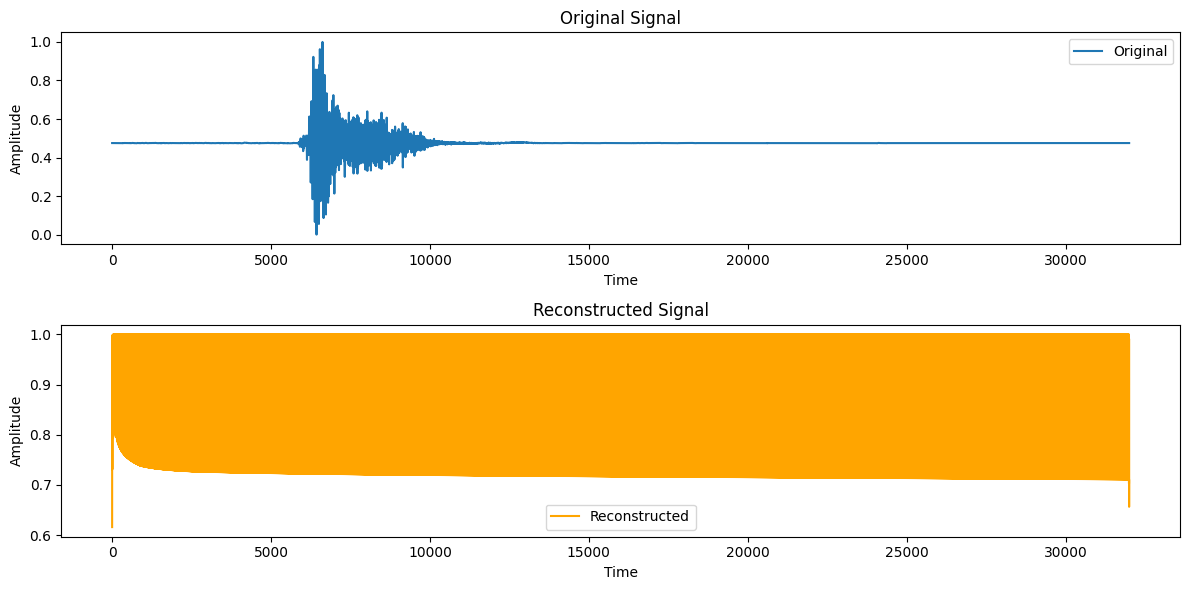

In [ ]:
random_idx = random.randint(0, len(dataset) - 1)
sample_data = dataset[random_idx].unsqueeze(0)

model.eval()
with torch.no_grad():
    reconstructed_data = model(sample_data)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(sample_data.cpu().squeeze().numpy(), label='Original')
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(reconstructed_data.cpu().squeeze().numpy(), label='Reconstructed', color='orange')
plt.title('Reconstructed Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

plt.show()